In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import Libraries

In [34]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, precision_recall_curve
from urllib.request import urlretrieve
import seaborn as sns



# Import data

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# Data Understanding

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
# We create a feature using the cabin letter.
train['cabin_letter'] = train['Cabin'].str[0]
test['cabin_letter'] = test['Cabin'].str[0]

# We create lists with the features according to their types
numeric = ['Age','Fare']
categorical = ['Pclass','Sex', 'SibSp','Parch','Embarked', 'cabin_letter']

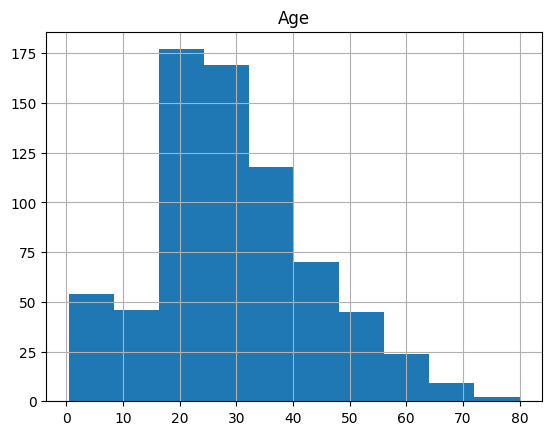

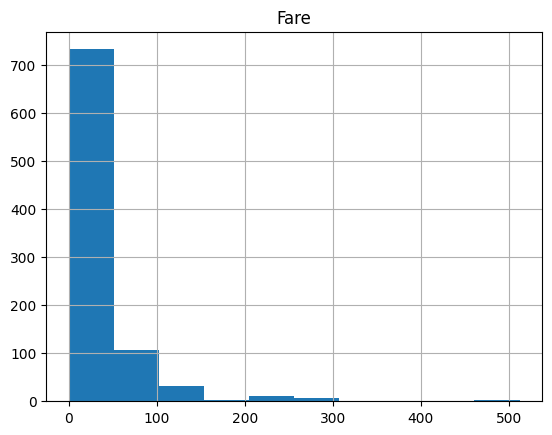

In [10]:
#We create an histogram for each numerical feature to understand their distribution and to spot any outliers 
for feature in numeric:
    train[feature].hist()
    plt.title(feature)
    plt.show()

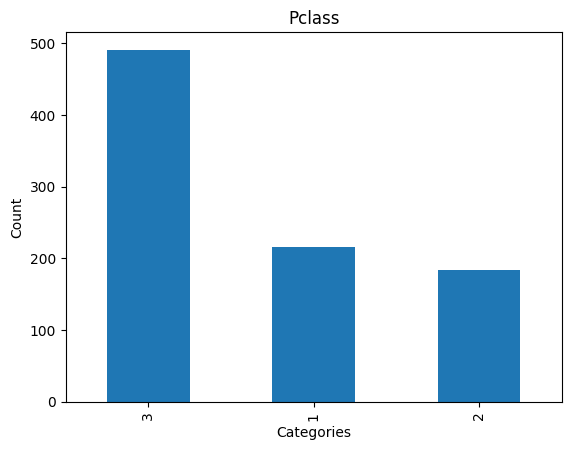

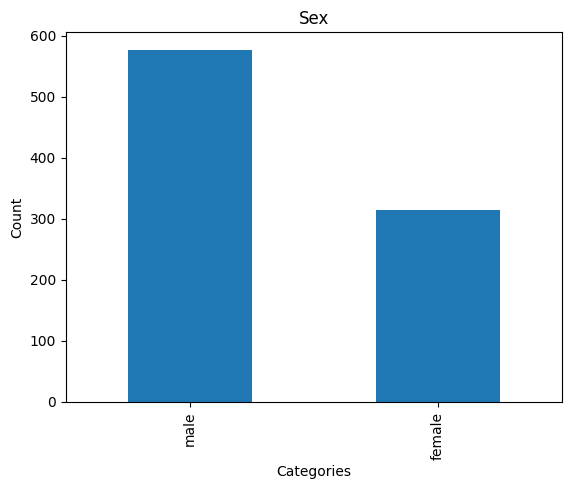

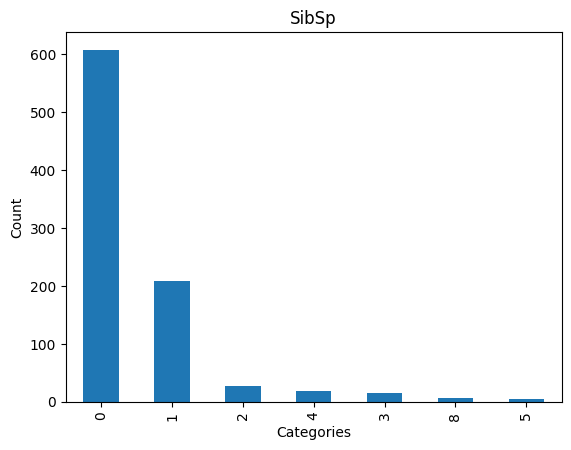

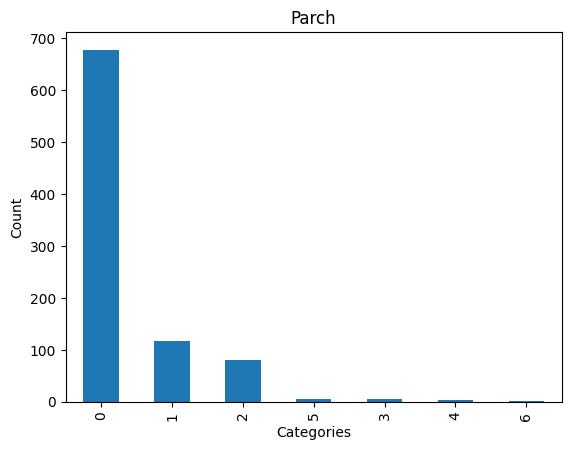

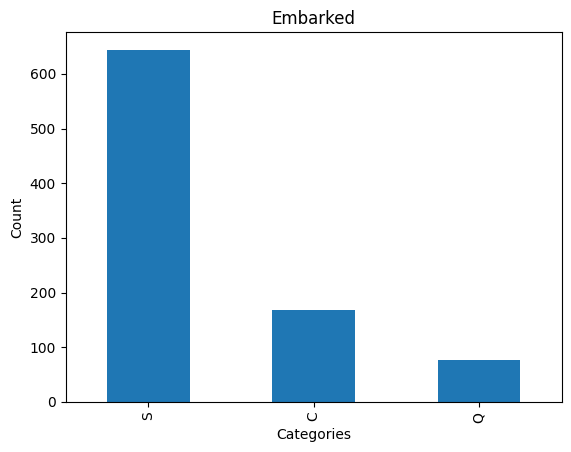

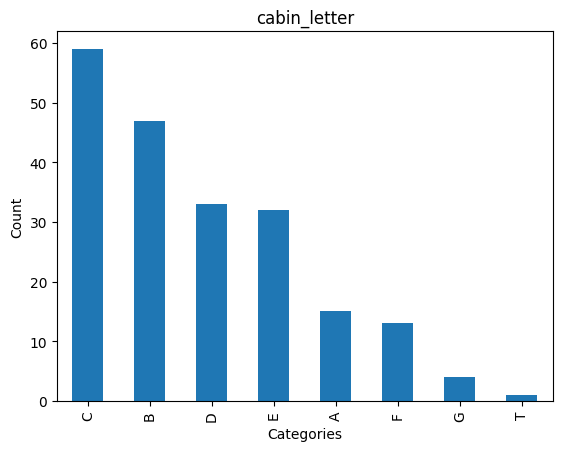

In [11]:
for feature in categorical:
    train[feature].value_counts().plot(kind='bar')
    plt.title(feature)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.show()


### Relationship between features and target

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN


In [13]:
categorical

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'cabin_letter']

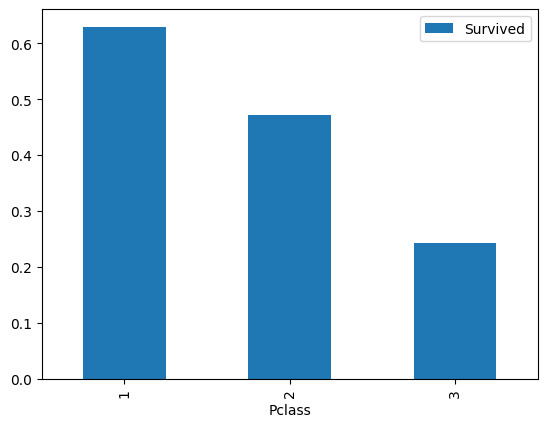

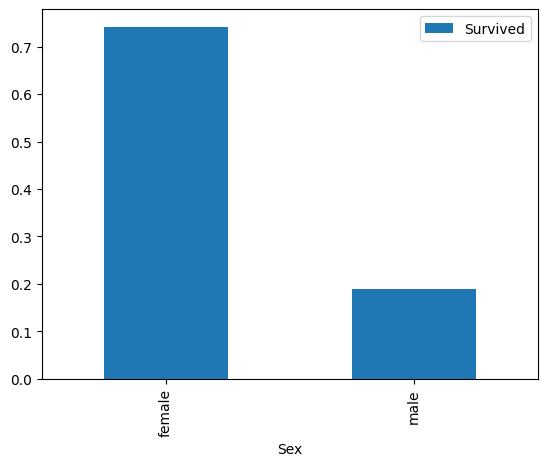

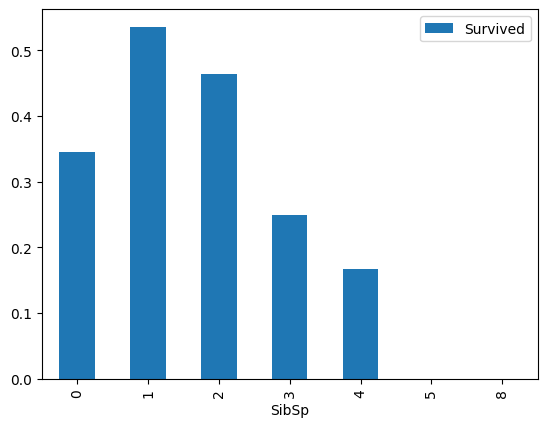

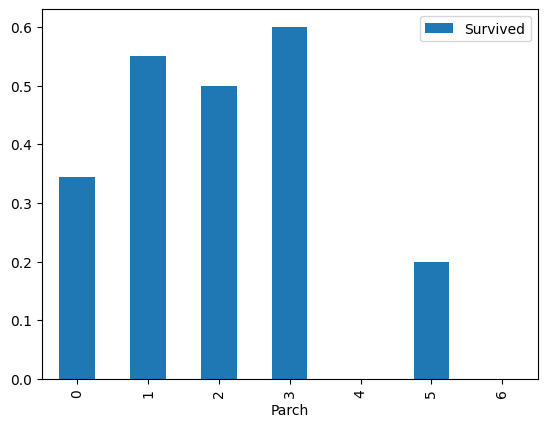

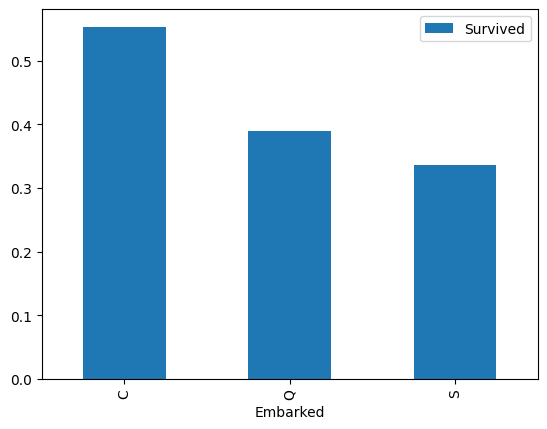

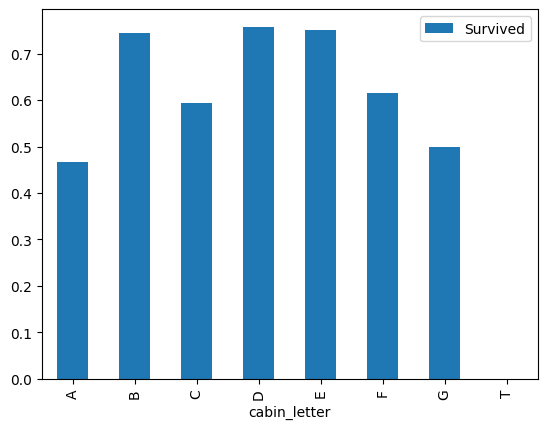

In [14]:
for feature in categorical:
    grouped = train[[feature, 'Survived']].groupby(by=[feature]).mean()
    grouped.plot(kind='bar')
    plt.show()

In [15]:
correlations = train[numeric +['Survived']].corr()['Survived']
correlations

Age        -0.077221
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

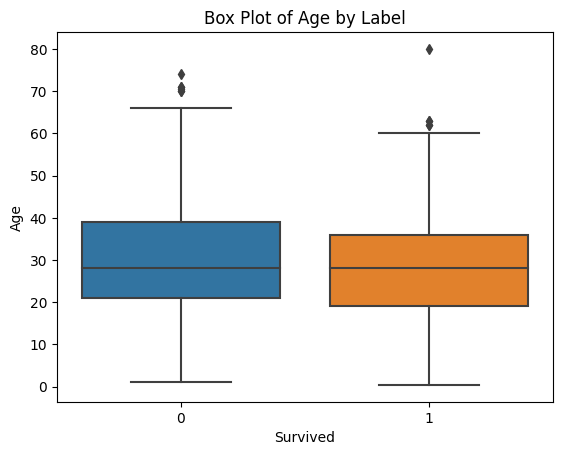

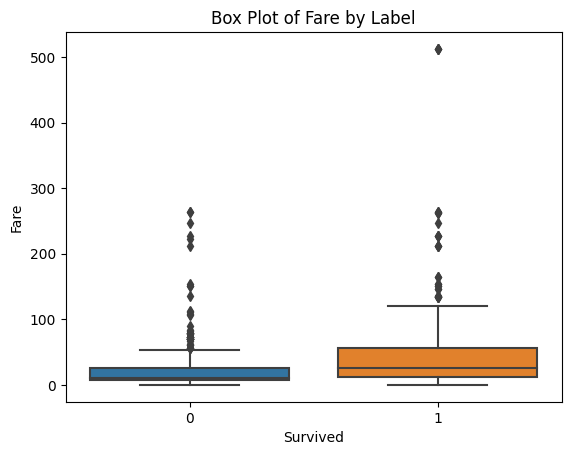

In [16]:
for feature in numeric:
    sns.boxplot(x='Survived', y=feature, data=train)
    plt.title(f'Box Plot of {feature} by Label')
    plt.show()

# Data Preprocessing

Fill null values of features with missing data

In [17]:
# Fill null values of age and fare
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(train['Age'].median())
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

In [18]:
# We create a new feature with the family size
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

In [1]:
test.head()

NameError: name 'test' is not defined

## One Hot Encoding 

In [20]:
# We get only the features we will use
features = ['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'cabin_letter',
       'FamilySize']

# Train val split
X_train, X_val, y_train, y_val = train_test_split(train[features], train['Survived'] , test_size = 0.3)

# We create a similar dataframe for the test data
X_test = test[features]

In [21]:
# We get the non categorical column names in a list
non_categorical = [column for column in X_train if column not in categorical]

# Create the ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ],
    remainder='passthrough'  # Keeps the rest of the columns unchanged
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform the training data
X_train_encoded = preprocessor.transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=preprocessor.get_feature_names_out())

cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
# Rename the columns
X_train_encoded.columns = list(cat_feature_names) + non_categorical

#Transform the test and validation data and repeat the same process
X_test_encoded = preprocessor.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=preprocessor.get_feature_names_out())
X_test_encoded.columns = list(cat_feature_names) + non_categorical

X_val_encoded = preprocessor.transform(X_val)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=preprocessor.get_feature_names_out())
X_val_encoded.columns = list(cat_feature_names) + non_categorical

# Convert one-hot encoded columns to int
X_train_encoded[cat_feature_names] = X_train_encoded[cat_feature_names].astype(int)
X_val_encoded[cat_feature_names] = X_val_encoded[cat_feature_names].astype(int)
X_test_encoded[cat_feature_names] = X_test_encoded[cat_feature_names].astype(int)


# Rename the columns
X_test_encoded.columns = list(cat_feature_names) + non_categorical

# Model Estimation

In [22]:
# Create the XGBoost Classifier
classifier = xgb.XGBClassifier(objective='binary:logistic')
# Fit model on training data
classifier.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
preds_val = classifier.predict_proba(X_val_encoded)

In [57]:
preds_1 = [sublist[1] for sublist in preds_val]


[0.9935033,
 0.0064554354,
 0.3707107,
 0.16119619,
 0.99694353,
 0.077540934,
 0.9758164,
 0.16020635,
 0.009617302,
 0.7950939,
 0.9977018,
 0.74192005,
 0.020520622,
 0.9732203,
 0.9957431,
 0.067297645,
 0.9970285,
 0.991662,
 0.96298426,
 0.3033695,
 0.002407245,
 0.09407458,
 0.032556634,
 0.96769184,
 0.057155028,
 0.09689776,
 0.6126134,
 0.027781479,
 0.016282555,
 0.19848558,
 0.093029395,
 0.24026991,
 0.9913935,
 0.04691801,
 0.29328224,
 0.6362921,
 0.013526071,
 0.041764747,
 0.0431633,
 0.98380095,
 0.011177067,
 0.99887484,
 0.8214714,
 0.17755342,
 0.09177935,
 0.47168112,
 0.031919647,
 0.0058616917,
 0.004123387,
 0.003268942,
 0.40680915,
 0.0017951628,
 0.086091004,
 0.025892664,
 0.9317159,
 0.056740455,
 0.04691801,
 0.64464283,
 0.049901195,
 0.041383583,
 0.10772917,
 0.012395728,
 0.9896207,
 0.98925716,
 0.008695048,
 0.9936952,
 0.02717237,
 0.022565741,
 0.0020139234,
 0.7939746,
 0.8535735,
 0.55254793,
 0.99446154,
 0.022820923,
 0.024540238,
 0.00780251,

In [59]:
precision, recall, thresholds = precision_recall_curve(y_val, preds_1)

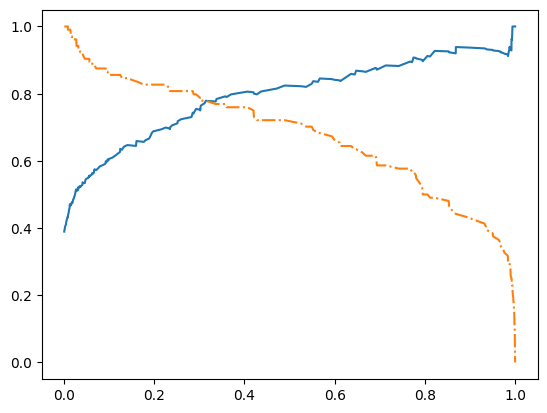

In [68]:
plt.plot(thresholds, precision[1:])
plt.plot(thresholds, recall[1:], '-.')

plt.show()